# Critical Scale Invariance in a Healthy Human Heart Rate

### Description

In this project you will analyse from a physics perspective time series of human heart rate. You will demonstrate the robust scale-invariance in the probability density function (PDF) of detrended healthy human heart rate increments. Moreover, you will show that such increments are not Gaussian distributed, but they display fat tails. This scale-independent and fractal structure supports the view that a healthy human heart rate is controlled to converge continually to a critical state.

### References

* Original paper: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.93.178103


### Assignment

1. build the cumulative time series B(i) from the detrended and normalised heart beat time series b(i)
2. Do a polynomial fit of B(i)
3. Calculate the  increments (fluctuation) from the polynomial fit
4. Build the increments PDF and fit it with Gaussian and non Gaussian distributions.
5. Test the scale invariance of the PDFs by collapse plot



### Contacts

Samir Suweis <samir.suweis@unipd.it>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from obspy.signal.detrend import polynomial


In [30]:
#list the files
filelist = os.listdir("rr_data")
#read them into pandas
df_list = [pd.read_csv(f'rr_data/{file}',delimiter = "\t",names=[f'{file}']) for file in filelist]
min_len = min(map(len, df_list))
small_df = pd.concat(df_list,axis=1)
big_df = (small_df.T).apply(pd.to_numeric, errors='coerce')
cropped_df = big_df.iloc[:,:min_len]
batch1 = cropped_df.iloc[:,:int(cropped_df.shape[1]/2)]
batch2 = cropped_df.iloc[:,int(cropped_df.shape[1]/2):]

In [31]:
#Reject the outliers

In [47]:
#integrating
df_cum1 = batch1.cumsum(axis = 1, skipna = True)
df_cum2 = batch2.cumsum(axis = 1, skipna = True)

In [70]:
#Detrending
def detrend(df, s_vals, p_order):
    N = int(np.floor(df.shape[1]/s_vals[-1]))
    no_pats= df.shape[0]
    Delta_S_B=np.zeros((len(s_vals),N,no_pats))
    for j in range(no_pats):
      row = df.iloc[j,:]
      for idx, s in enumerate(s_vals):
        intval = int(np.floor(N/(2*s)))
        detrended_row = np.zeros(df.shape[1])
        for i in range(intval):
          detrended_row[i * 2 * s: (i + 1) * 2 * s] = polynomial(row[i * 2 * s: (i + 1) * 2 * s], p_order, plot=False)
          #polynomial(row[i*2*s:(i+1)*2*s],p_order, plot =False)    
        #polynomial(row[i*2*s:(i+1)*2*s],p_order, plot =False)
        detrended_row[intval*2*s:] = polynomial(row[intval*2*s:], p_order, plot=False)
        Delta_S_B[idx,:,j]=np.array([detrended_row[i+s]-detrended_row[i] for i in range(N)])
        #Delta_S_B[idx,:,j]=np.array([row[i+s]-row[i] for i in range(N)])
        
      # Normalize Delta_S_B for each patient
      std = np.std(Delta_S_B[:, :, j], axis=1)
      Delta_S_B[:, :, j] /= std[:, None] 
    return Delta_S_B

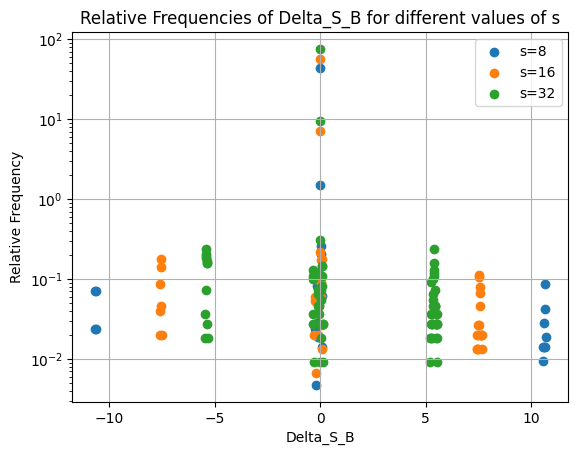

In [75]:
s_vals = [2**i for i in range(3,6)]
Delta_S_B = detrend(df_cum1,s_vals, 3)
# Plot histograms for each s separately using NumPy's histogram function
plt.figure()
for idx, s in enumerate(s_vals):
    histogram, bins = np.histogram(Delta_S_B[idx].flatten(), bins=1000, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.scatter(bin_centers, (histogram), label=f's={s}')
plt.yscale('log')
plt.title('Relative Frequencies of Delta_S_B for different values of s')
plt.xlabel('Delta_S_B')
plt.ylabel('Relative Frequency')
plt.legend()
plt.grid(True)
plt.show()
